# Building a Decision Tree with Scikit-Learn

In this notebook, we'll take a look at a dataset provided by Scikit-Learn that classifies wine into 3 different categories. We'll use the data to build a Decision Tree Classifier, and see how well our model can classify the wines based on a variety of factors.

## Libraries and Data Collection
First things first- let's install/import the necessary libraries and get the data from sklearn.

In [1]:
pip install -qq seaborn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn import metrics
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text, plot_tree

We'll use the **load_wine** function from sklearn to gather the data. Included in the return object are the following attributes:
- **data**: a pandas DataFrame containing the data for each wine
- **target**: a pandas Series containing the class for each wine
- **feature_names**: a list of the dataset column names
- **target_names**: a list of the wine classes
- **frame**: a DataFrame with both *data* and *target*
- **DESCR**: a description of the dataset

In [3]:
data = load_wine(return_X_y=False, as_frame=True)
df = data.data # dataframe without the class of the wine as a column
df_frame = data.frame # dataframe with the class of the wine as a column
df_frame.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


## Correlations
We can use some handy tools provided by Pandas and Seaborn to visualize the correlation between variables in our dataset.

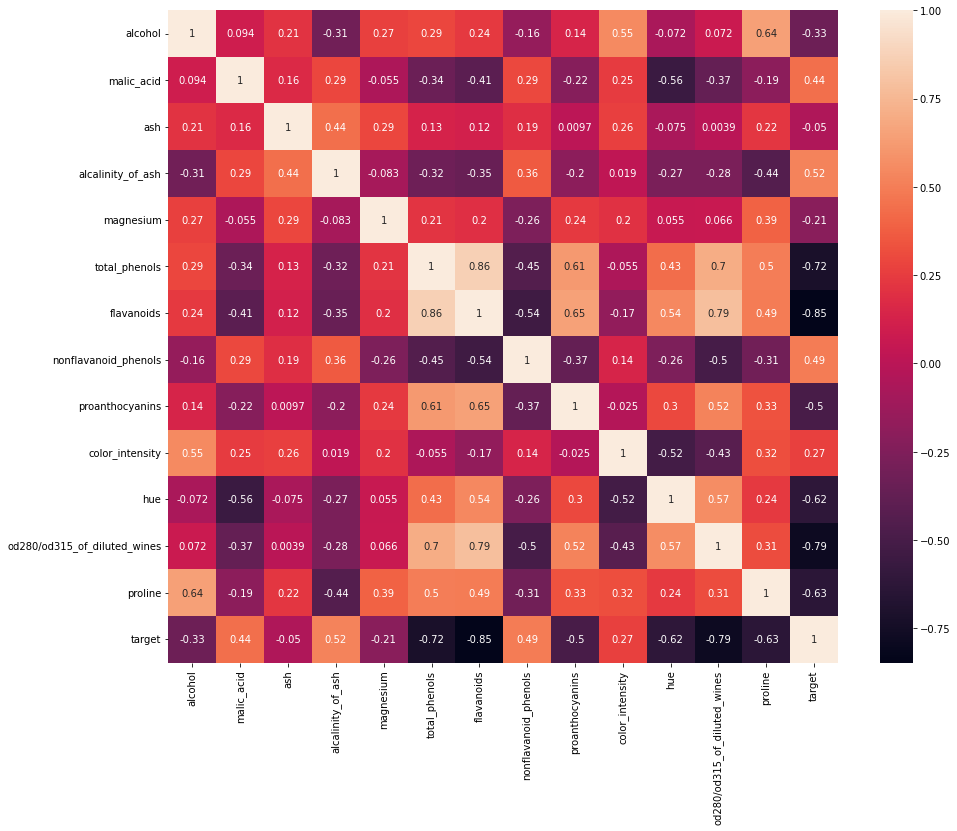

In [4]:
plt.figure(figsize=(15, 12))
cmap = df_frame.corr() # compute the correlation of each column
sns.heatmap(cmap, annot=True)
plt.show()

If we look at the correlations of each variable with the **target** column, we see that some of them are more correlated than others. Let's get rid of a few of the *least* relevant columns:

In [5]:
cmap_target = abs(cmap["target"])
relevant_features = cmap_target[cmap_target>0.3]
relevant_features

alcohol                         0.328222
malic_acid                      0.437776
alcalinity_of_ash               0.517859
total_phenols                   0.719163
flavanoids                      0.847498
nonflavanoid_phenols            0.489109
proanthocyanins                 0.499130
hue                             0.617369
od280/od315_of_diluted_wines    0.788230
proline                         0.633717
target                          1.000000
Name: target, dtype: float64

In [6]:
dropped_features = cmap_target[cmap_target<0.3]
dropped_features # These are the features that we won't use in our model

ash                0.049643
magnesium          0.209179
color_intensity    0.265668
Name: target, dtype: float64

In [7]:
dropped_list = dropped_features.index.tolist()
X = df_frame.drop(dropped_list, axis=1)
X.head()

,alcohol,malic_acid,alcalinity_of_ash,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,15.6,2.80,3.06,0.28,2.29,1.04,3.92,1065.0,0
1,13.20,1.78,11.2,2.65,2.76,0.26,1.28,1.05,3.40,1050.0,0
2,13.16,2.36,18.6,2.80,3.24,0.30,2.81,1.03,3.17,1185.0,0
3,14.37,1.95,16.8,3.85,3.49,0.24,2.18,0.86,3.45,1480.0,0
4,13.24,2.59,21.0,2.80,2.69,0.39,1.82,1.04,2.93,735.0,0


## Visualizing the features
Let's take a look at the remaining columns in our data, and see how they are separated in the three classes. If we can visually identify how each class is similar/different for each category, then our classification model has a good chance of being accurate.
<br><br>
The following code will print a distribution graph and a box-plot for each feature, separated into the three classes of wines.

alcohol


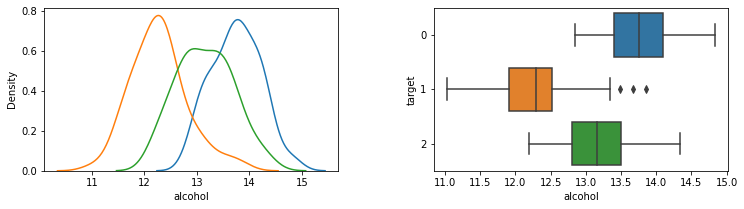

malic_acid


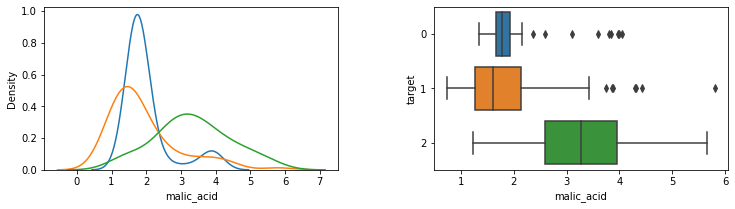

alcalinity_of_ash


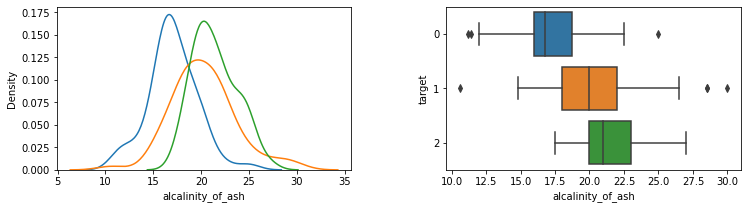

total_phenols


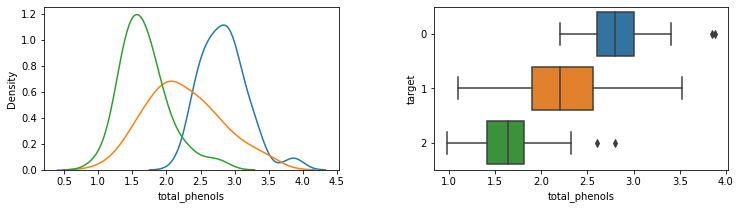

flavanoids


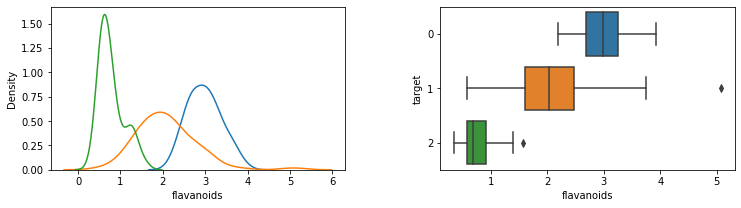

nonflavanoid_phenols


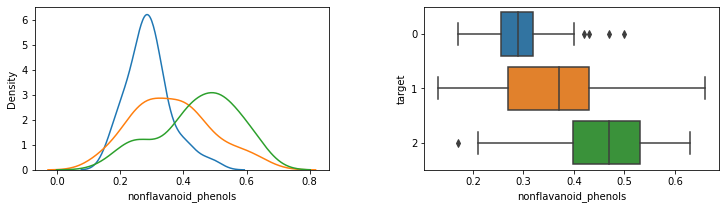

proanthocyanins


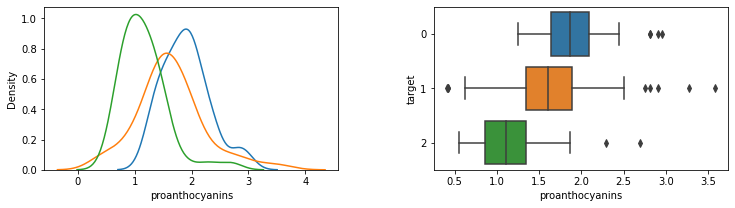

hue


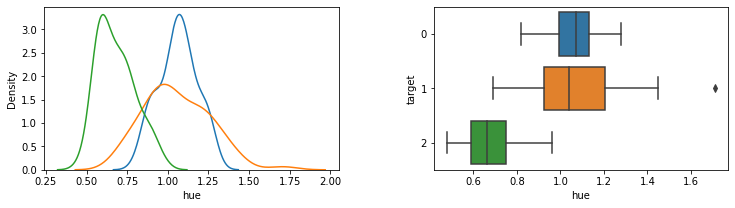

od280/od315_of_diluted_wines


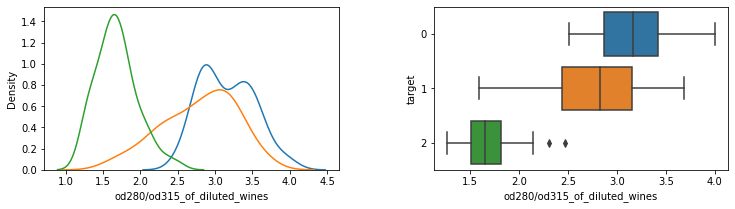

proline


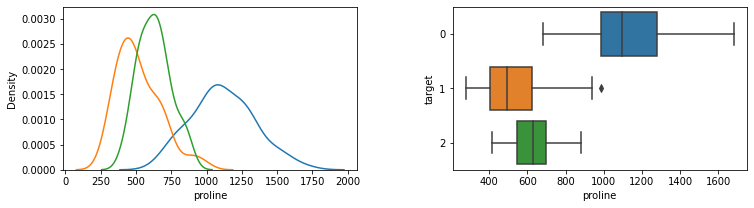

In [8]:
for feature in X.columns:
    if feature == "target":
        continue
    print(feature)
    fig = plt.figure()
    fig.set_figheight(3)
    fig.set_figwidth(20)
    gs1 = gridspec.GridSpec(1,3, width_ratios=[2,0.1,2])
    ax1 = plt.subplot(gs1[0, 0])
    ax2 = plt.subplot(gs1[0, 2])
    gs1.update(right=0.60)
    sns.boxplot(x=feature,y='target',data=X, orient="h", ax=ax2)
    sns.kdeplot(X[feature][X['target']==0],ax=ax1,label='0')
    sns.kdeplot(X[feature][X['target']==1],ax=ax1,label='1')
    sns.kdeplot(X[feature][X['target']==2],ax=ax1,label='2')
    plt.show()

## Build the model
Looking at the distributions of each column, there is plenty of overlap in between the three classes of wines. But some of the features, like alcohol, have a clear difference in the **mean** value. Let's see how a decision tree classifier can perform with these variables:

We'll start by splitting the data into **training** data and **evaluation** data:

In [9]:
X = X.drop(columns="target")
y = df_frame["target"].astype('string')
feature_names = X.columns
labels = y.unique()

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2, random_state=1)

Next, we'll use the **DecisionTreeClassifier** function from sklearn to create the classifier:

In [10]:
clf = DecisionTreeClassifier(max_depth=5,random_state=0)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=0)

Your model is complete! To visualize how the model is constructed, we'll use the **plot_tree** function to see the decisions are formed:

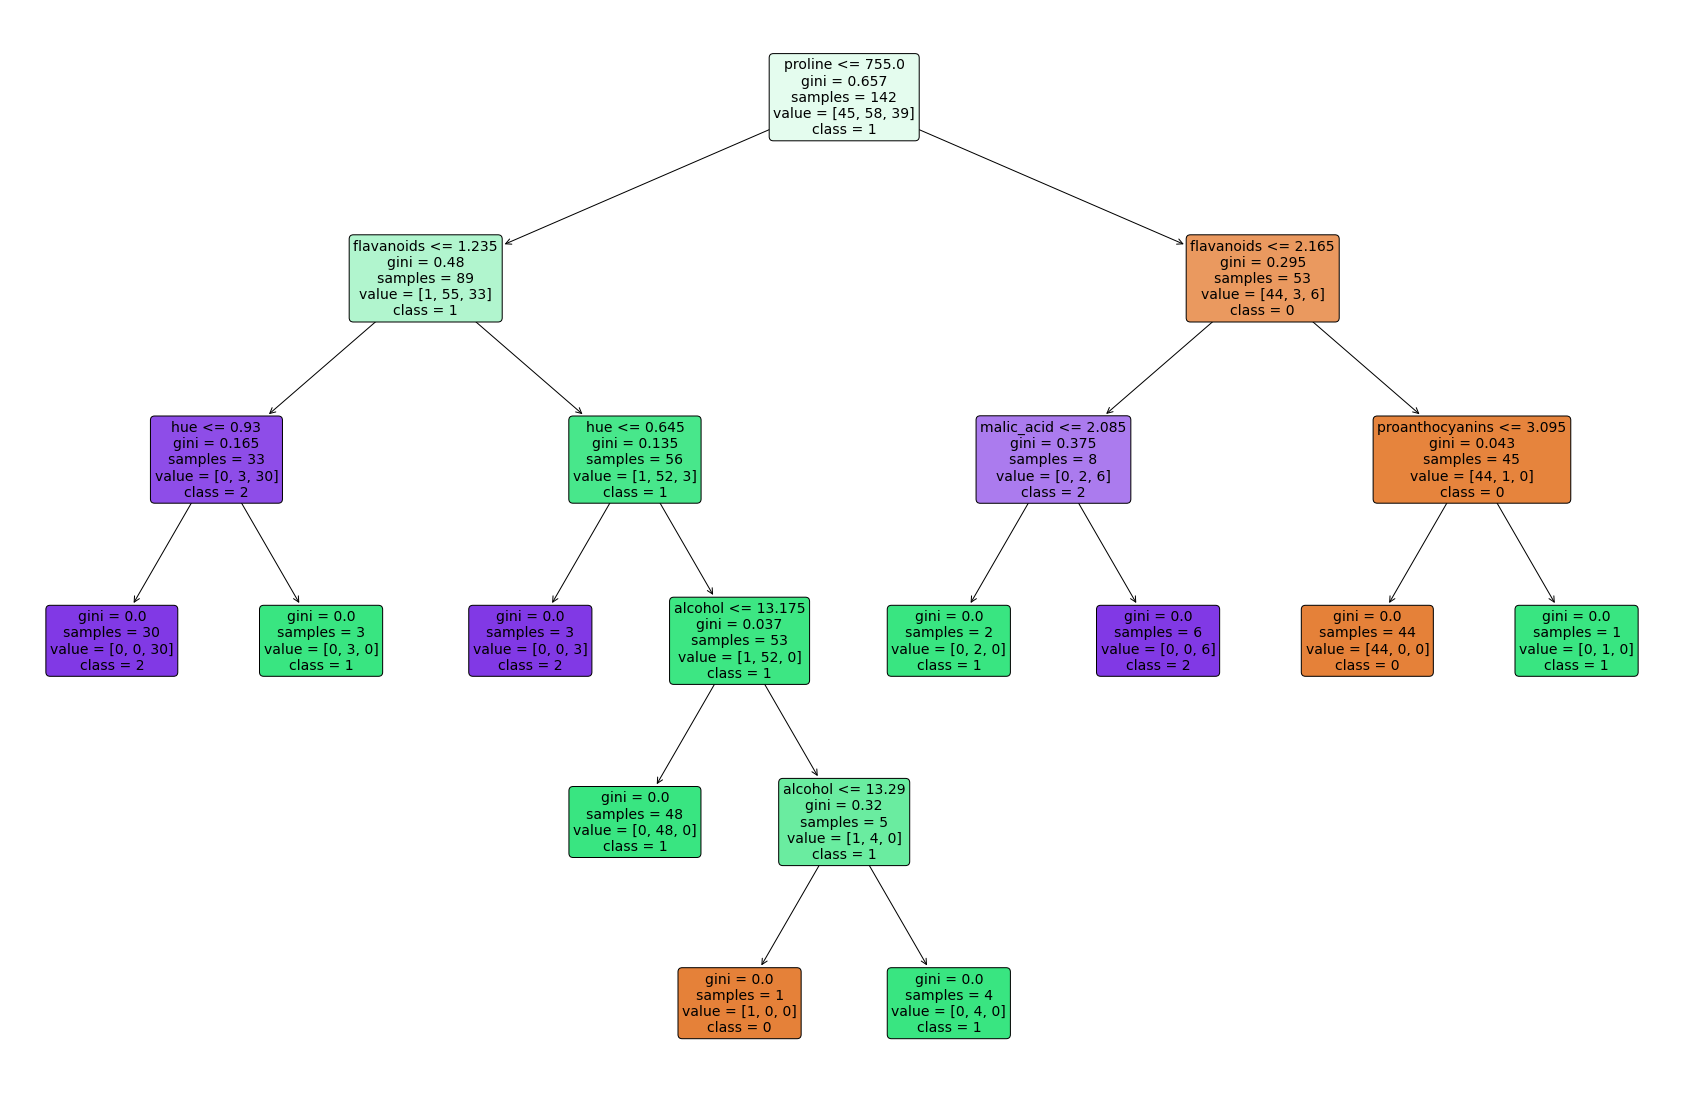

In [11]:
plt.figure(figsize=(30,20))
a = plot_tree(
    clf,
    feature_names = feature_names,
    class_names = labels,
    rounded = True,
    filled = True,
    fontsize=14
)
plt.show()

Or if you want a more concise view, you can view a textual representation of the tree using **export_text**:

In [12]:
tree_rules = export_text(clf,feature_names = list(feature_names))
print(tree_rules)

|--- proline <= 755.00
|   |--- flavanoids <= 1.24
|   |   |--- hue <= 0.93
|   |   |   |--- class: 2
|   |   |--- hue >  0.93
|   |   |   |--- class: 1
|   |--- flavanoids >  1.24
|   |   |--- hue <= 0.64
|   |   |   |--- class: 2
|   |   |--- hue >  0.64
|   |   |   |--- alcohol <= 13.17
|   |   |   |   |--- class: 1
|   |   |   |--- alcohol >  13.17
|   |   |   |   |--- alcohol <= 13.29
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- alcohol >  13.29
|   |   |   |   |   |--- class: 1
|--- proline >  755.00
|   |--- flavanoids <= 2.17
|   |   |--- malic_acid <= 2.08
|   |   |   |--- class: 1
|   |   |--- malic_acid >  2.08
|   |   |   |--- class: 2
|   |--- flavanoids >  2.17
|   |   |--- proanthocyanins <= 3.10
|   |   |   |--- class: 0
|   |   |--- proanthocyanins >  3.10
|   |   |   |--- class: 1



## Testing
Now that our model is complete, let's see how it performs against our evaluation data:

In [13]:
test_pred_decision_tree = clf.predict(X_val)

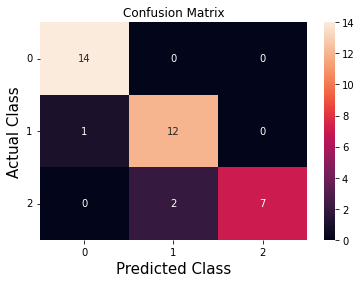

<Figure size 1080x720 with 0 Axes>

In [14]:
confusion_matrix = metrics.confusion_matrix(y_val,test_pred_decision_tree)
matrix_df = pd.DataFrame(confusion_matrix)
ax = plt.axes()
plt.figure(figsize=(15,10))
sns.heatmap(matrix_df, annot=True, ax=ax)
ax.set_title('Confusion Matrix')
ax.set_xlabel("Predicted Class", fontsize =15)
ax.set_xticklabels(labels)
ax.set_ylabel("Actual Class", fontsize=15)
ax.set_yticklabels(list(labels), rotation = 0)
plt.show()

The confusion matrix above tells us that it was mostly accurate. There were 2 wines that were predicted to be **Class 1**, when they were actually **Class 2**, and 1 that was predicted to be **Class 0**, when it was actually **Class 1**.

We can see the total accuracy using **metrics**:

In [15]:
metrics.accuracy_score(y_val, test_pred_decision_tree)

0.9166666666666666

In [16]:
print(metrics.classification_report(y_val,test_pred_decision_tree))

              precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       0.86      0.92      0.89        13
           2       1.00      0.78      0.88         9

    accuracy                           0.92        36
   macro avg       0.93      0.90      0.91        36
weighted avg       0.92      0.92      0.92        36



We can also see the importance of each column in the model:

In [17]:
importance = pd.DataFrame({'feature': X_train.columns,'importance' : np.round(clf.feature_importances_, 3)})
importance.sort_values('importance', ascending=False, inplace = True)
print(importance)

                        feature  importance
4                    flavanoids       0.433
9                       proline       0.374
7                           hue       0.118
1                    malic_acid       0.032
0                       alcohol       0.021
6               proanthocyanins       0.021
2             alcalinity_of_ash       0.000
3                 total_phenols       0.000
5          nonflavanoid_phenols       0.000
8  od280/od315_of_diluted_wines       0.000
